In [1]:
import os


import pprint
import random
import numpy as np
import pandas as pd

import spacy
import sys
sys.path.append("../")
from datatools.analyzer import *
# from datatools.analyzer import clean_text
from error_tools import *

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from nltk.lm        import Vocabulary
from nltk.lm.models import MLE
from nltk.util      import ngrams

In [9]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
error_types = ['Unclear intention', 'Wrong information',
 'Ignore question', 'Topic transition error', 
 'Lack of information', 'Repetition', 
 'Contradiction', 'Self-contradiction',
  'Lack of common sense', 'Semantic error',
   'Grammatical error', 'Ignore proposal', 
   'Ignore offer', 'Lack of sociality', 
   'Uninterpretable', 'Ignore greeting', 
   'No-Err']


In [10]:
convs = read_conv(path, datalist)

In [58]:
usr_utt = []
for conv in convs:
    for i, ut in enumerate(conv):
        if not ut.is_system():
            usr_utt.append(clean_text(ut.utt))
            

In [1]:
from tqdm import tqdm
def extract_utt_nucc(path):
    files = os.listdir(path)
    nucc_convs = []
    for filename in tqdm(files):
        if ".json" not in filename:
            continue
        # name = filename.split(".")[0]
        with open(path+filename, "r") as f:
            data  = json.load(f)
            for conv in data["turns"]:
                utt = conv["utterance"]
                if len(nlp(utt)) < 2:
                    # print(utt)
                    continue
                nucc_convs.append(utt)
    return nucc_convs

In [2]:
# nuccデータ
nucc_path = "../../corpus/nucc/conv2/"
nucc_convs = extract_utt_nucc(nucc_path)

  0%|          | 0/91 [00:00<?, ?it/s]


NameError: name 'json' is not defined

In [61]:
usr_utt += nucc_convs

In [62]:
filled_normal = fill_SYMBOL( sentence2normalize_nv(usr_utt) )

In [63]:
def create_language_model(sentences, N):
    vocab = Vocabulary([word for sent in sentences for word in sent])
    text_ngrams = [ngrams(sent, N) for sent in sentences]
    lm = MLE(order=N, vocabulary=vocab)
    lm.fit(text_ngrams)
    return lm

In [64]:
n=3
lm = create_language_model(filled_normal, N=n)

In [65]:
context = ("そう", 'です')

In [66]:
len(usr_utt)

2000

In [67]:
print(context, '->')

('そう', 'です') ->


In [68]:
prob_list = []
for word in lm.context_counts(lm.vocab.lookup(context)): # 文脈に続く単語一覧の取得
    prob_list.append((word, lm.score(word, context))) # 単語のその出現する確率を格納

prob_list.sort(key=lambda x: x[1], reverse=True) # 出現確率順にソート
for word, prob in prob_list:
    print('\t{:s}: {:f}'.format(word, prob))

	ね: 0.734513
	か: 0.150442
	よ: 0.070796
	。: 0.017699
	けど: 0.008850
	EOS: 0.008850
	が: 0.008850


In [21]:
import math
import pprint
def sentence2score(sentence, l, N):
    filled = fill_SYMBOL( sentence2normalize_nv(sentence) )
    print(filled)
    ngram_text = []
    for L in filled:
        for i in range(len(L)-N+1):
            # print(L[i:i+N])
            ngram_text.append(L[i:i+N])
    pprint.pprint(ngram_text)
    all_score = 0
    for ngram in ngram_text:
        context = (ngram[:-1])
        # print(context)
        # for word in lm.context_counts(lm.vocab.lookup(context)): # 文脈に続く単語一覧の取得
            
        score = lm.score(ngram[-1], context) + 1e-4
        # print(score)
        log_score = math.log2(score)
        all_score += log_score
    # print(all_score/len(ngram_text))
    return all_score/len(ngram_text)
    

In [24]:
sentence = "最近とても暑いですから。"
sentence2score(sentence, lm, N=n)

[['FOS', 'FOS', '名詞-普通名詞-副詞可能', 'とても', '暑い', 'です', 'から', '。', 'EOS', 'EOS']]
[['FOS', 'FOS', '名詞-普通名詞-副詞可能'],
 ['FOS', '名詞-普通名詞-副詞可能', 'とても'],
 ['名詞-普通名詞-副詞可能', 'とても', '暑い'],
 ['とても', '暑い', 'です'],
 ['暑い', 'です', 'から'],
 ['です', 'から', '。'],
 ['から', '。', 'EOS'],
 ['。', 'EOS', 'EOS']]


-2.548092108927089

In [4]:
from datatools.maneger import DataManager

In [5]:
modelM = DataManager("../models/utterance/")

In [81]:
model_name = "LM_nucc.pickle"
modelM.save_data(model_name, lm)

success save : ../models/utterance/LM_plain.pickle


In [6]:
lm = modelM.load_data("LM_nucc.pickle")

success load : ../models/utterance/LM_nucc.pickle


In [12]:
errors = ['Grammatical error', "Uninterpretable"]

y = []
n=3
y_pred = []
for conv in convs:
    for ut in conv:
        if not ut.is_system():
            continue
        # エラーなら1
        if ut.is_error_included(errors):
            # print(ut)
            y.append(1)
        else:
            y.append(0)
        #LM 判定
        # エラーなら1
        if sentence2score(ut.utt, lm, N=n) < -5.6:
            y_pred.append(1)
        else:
            y_pred.append(0)

        

In [25]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y, y_pred=y_pred))

print('EM:', metrics.accuracy_score(y, y_pred))
print('F-measure: ', metrics.f1_score(y, y_pred))

confusion matrix = 
 [[1668  528]
 [   2    2]]
accuracy =  0.759090909090909
EM: 0.759090909090909
F-measure:  0.00749063670411985


In [26]:
for conv in convs:
    for ut in conv:
        if sentence2score(ut.utt, lm, N=3) < -5.5:
            # print(ut.utt)
            pass
        else:
            # print(ut.utt)
            pass

[['FOS', 'FOS', 'こんばんは', '！', 'EOS', 'EOS'], ['FOS', 'FOS', '名詞-普通名詞-一般', 'へ', '動詞-非自立可能', 'たい', 'ね', '。', 'EOS', 'EOS']]
[['FOS', 'FOS', 'こんばんは'],
 ['FOS', 'こんばんは', '！'],
 ['こんばんは', '！', 'EOS'],
 ['！', 'EOS', 'EOS'],
 ['FOS', 'FOS', '名詞-普通名詞-一般'],
 ['FOS', '名詞-普通名詞-一般', 'へ'],
 ['名詞-普通名詞-一般', 'へ', '動詞-非自立可能'],
 ['へ', '動詞-非自立可能', 'たい'],
 ['動詞-非自立可能', 'たい', 'ね'],
 ['たい', 'ね', '。'],
 ['ね', '。', 'EOS'],
 ['。', 'EOS', 'EOS']]
[['FOS', 'FOS', 'そう', 'です', 'ね', '。', 'EOS', 'EOS'], ['FOS', 'FOS', '名詞-普通名詞-副詞可能', 'とても', '暑い', 'です', 'から', '。', 'EOS', 'EOS']]
[['FOS', 'FOS', 'そう'],
 ['FOS', 'そう', 'です'],
 ['そう', 'です', 'ね'],
 ['です', 'ね', '。'],
 ['ね', '。', 'EOS'],
 ['。', 'EOS', 'EOS'],
 ['FOS', 'FOS', '名詞-普通名詞-副詞可能'],
 ['FOS', '名詞-普通名詞-副詞可能', 'とても'],
 ['名詞-普通名詞-副詞可能', 'とても', '暑い'],
 ['とても', '暑い', 'です'],
 ['暑い', 'です', 'から'],
 ['です', 'から', '。'],
 ['から', '。', 'EOS'],
 ['。', 'EOS', 'EOS']]
[['FOS', 'FOS', '名詞-普通名詞-一般', 'に', '動詞-非自立可能', 'ない', 'ん', 'です', 'ね', '？', 'EOS', 'EOS']]
[['FOS', 'FOS', '名詞-普通名詞-一般

KeyboardInterrupt: 

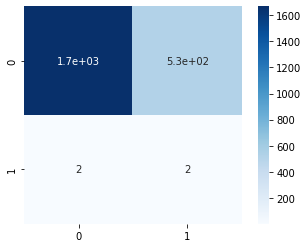

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=y, y_pred=y_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.savefig('sklearn_confusion_matrix.png')